<a href="https://colab.research.google.com/github/RayGone/DeepWeeds/blob/main/MobileNet/V3/Experiment1-AoM-OutPool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'deepweeds:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4419124%2F7615277%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T105246Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37326fc86c292a9c86ae76dbd9ce85c2159ac445561881f5144661f7548cb4fce70807c88359f6fee0c4bd09f1ecdafab60d72aad427d421855389cd3e07ce3d5c3936dc05ffa880792801b04eaf5caaba15cc77b249a8263b1f5b905c5b947b0aa3da3c5e9d057e90505f5dcc6ee0f8dffa0eb78bf2ea0cc80615220c2bcaf4436460df24788487c8e7228f4783107ba630aebfefbf6826c5b7fa87843d11cf298853c56f3cb310277ad71e2641fd4af8029eee74bc56618ec51456234d6b7b9b39ee011db2eb9b5d4acb955775ce7d788cdc2d7dc10312f57c446f09169ed05471a01c42b3881471a6ff330882e41fad363ad2d13aeb5f8e2568dc272bcdf1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 493010412 bytes downloaded
Downloaded and uncompressed: deepweeds
Data source import complete.


# DeepWeeds - MobileNet

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed)

In [29]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [30]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [31]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [32]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [33]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [47]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [48]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [49]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [50]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Creating Dateset ImageGenerator

In [51]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [52]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10506 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.


### Displaying Images

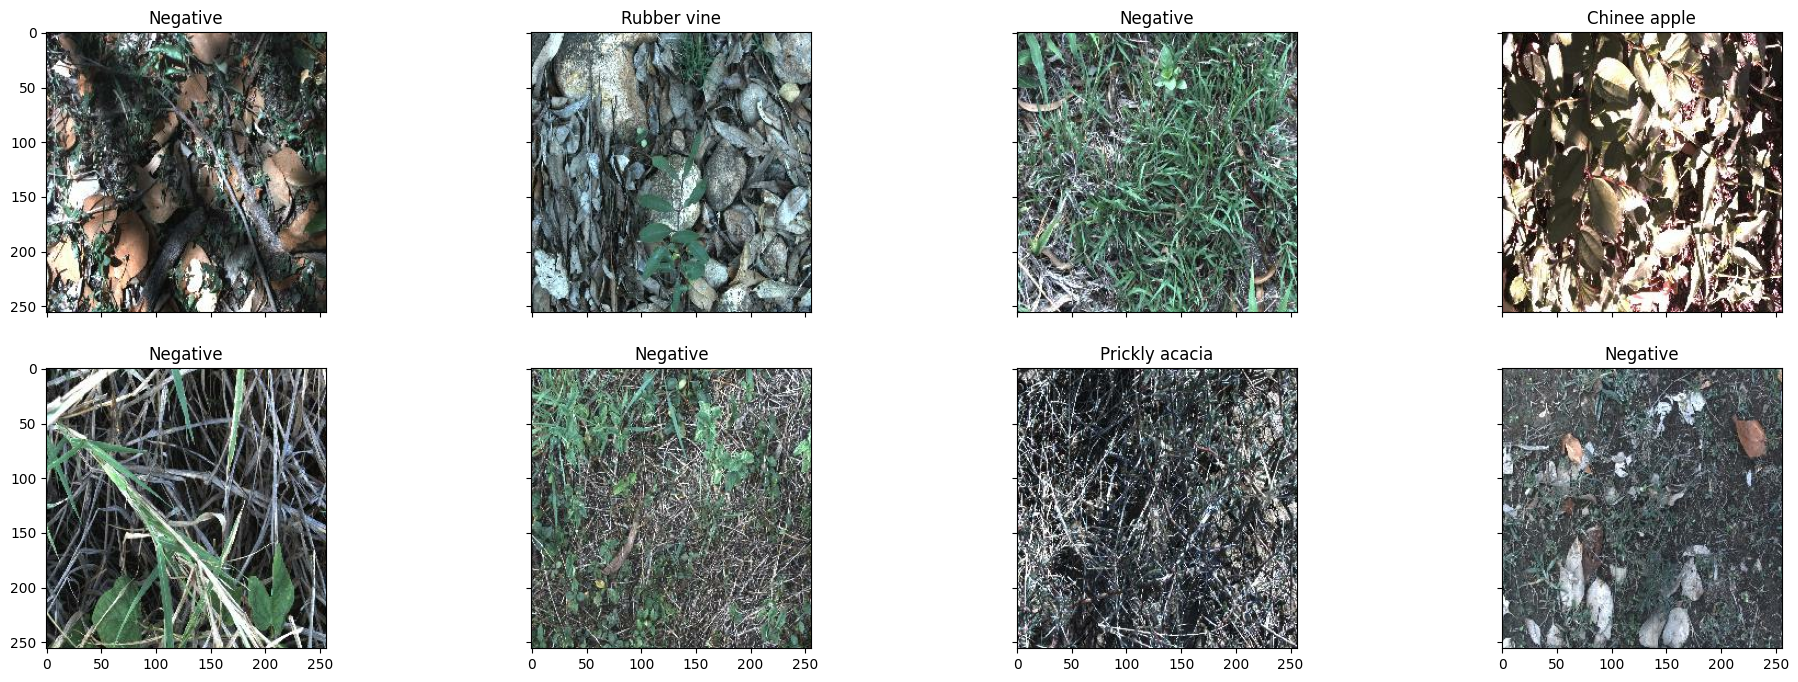

In [53]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [54]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

class SpatialMaxPooling2D(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,stride=None,padding='valid',**kwargs):
    super(SpatialMaxPooling2D,self).__init__(**kwargs)
    self.pool_size = pool_size
    self.stride = stride
    self.padding = padding
    if stride is None:
      self.stride = self.pool_size

    self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding)
    self.permute_forward = tf.keras.layers.Permute((3,1,2))
    self.permute_backward = tf.keras.layers.Permute((2,3,1))

  def build(self,input_shape):
    self.reshape_forward = tf.keras.layers.Reshape((input_shape[-1],-1))
    self.reshape_backward= tf.keras.layers.Reshape((-1, input_shape[1], input_shape[2]))

  def call(self,x, training):
    x = self.permute_forward(x)
    x = self.reshape_forward(x)
    x = self.max(x)
    x = self.reshape_backward(x)
    x = self.permute_backward(x)
    return x

## Building MobileNet Model

In [59]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large


def buildModel(train=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model = MobileNetV3Large(input_shape=(224,224,3), weights='imagenet', include_top=False)
    base_model.trainable = train
    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # Pre-process the input.
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Resizing(224, 224)(x)

    ## DAta Augmentation
    x = layers.RandomBrightness(0.3, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.3, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.4, 0.4, seed=seed)(x)
    x = layers.RandomZoom(0.1, 0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.01, seed=seed)(x)

    x = base_model(x, training=train)

    x = AverageOfMaximums(x, 3)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(9, activation='softmax')(x)

    model_name = "DeepWeeds-" + base_model.name.upper()
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [60]:
model = buildModel(True)
model.summary()

Base Model: MobilenetV3large
Model: "DeepWeeds-MOBILENETV3LARGE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 random_brightness_4 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_4 (RandomC  (None, 224, 224, 3)       0         
 ontrast)                                                        
                                                                 
 random_fli

## Trial 1 - FineTuning

In [61]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/200
329/329 [==============================] - 83s 165ms/step - loss: 1.6113 - accuracy: 0.5126 - val_loss: 0.9928 - val_accuracy: 0.6482 - lr: 2.0000e-04
Epoch 2/200
329/329 [==============================] - 52s 157ms/step - loss: 0.9550 - accuracy: 0.6665 - val_loss: 0.6969 - val_accuracy: 0.7624 - lr: 2.0000e-04
Epoch 3/200
329/329 [==============================] - 53s 161ms/step - loss: 0.7191 - accuracy: 0.7583 - val_loss: 0.5974 - val_accuracy: 0.7953 - lr: 2.0000e-04
Epoch 4/200
329/329 [==============================] - 52s 157ms/step - loss: 0.6156 - accuracy: 0.7867 - val_loss: 0.4674 - val_accuracy: 0.8424 - lr: 2.0000e-04
Epoch 5/200
329/329 [==============================] - 52s 158ms/step - loss: 0.5368 - accuracy: 0.8154 - val_loss: 0.4556 - val_accuracy: 0.8415 - lr: 2.0000e-04
Epoch 6/200
329/329 [==============================] - 52s 158ms/step - loss: 0.4887 - accuracy: 0.8314 - val_loss: 0.4011 - val_accuracy: 0.8621 - lr: 2.0000e-04
Epoch 7/200
329/329 [=

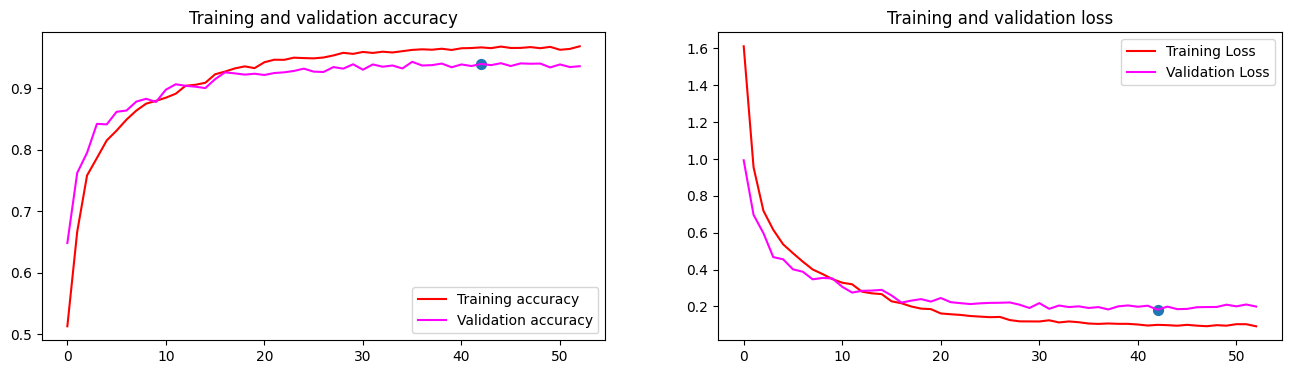

CPU times: user 50min 23s, sys: 3min 4s, total: 53min 27s
Wall time: 50min 47s


In [62]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 [==============================] - 7s 31ms/step - loss: 0.2002 - accuracy: 0.9349
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87963   0.84444   0.86168       225
       Lantana    0.95522   0.90566   0.92978       212
   Parkinsonia    0.95215   0.96602   0.95904       206
    Parthenium    0.90141   0.93659   0.91866       205
Prickly acacia    0.90610   0.90610   0.90610       213
   Rubber vine    0.91866   0.95050   0.93431       202
     Siam weed    0.98500   0.91628   0.94940       215
    Snake weed    0.89286   0.86207   0.87719       203
      Negative    0.95447   0.96705   0.96072      1821

      accuracy                        0.93975      3502
     macro avg    0.92728   0.91719   0.92188      3502
  weighted avg    0.93976   0.93975   0.93954      3502


                False Positive Rate  Accuracy
Chinee apple               0.007934  0.844444
Lantana                    0.002736  0.905660
Parkinsonia                0.003034  0.966019
Parthenium                 0.006369  0.936585
Prickly acacia    

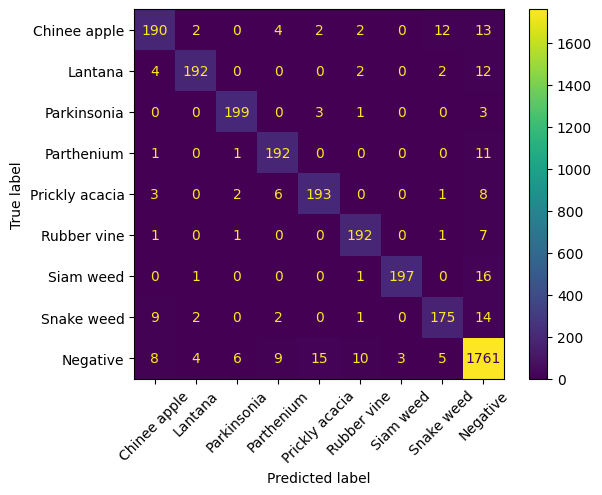

In [63]:
a, b = eval_model(model, validation_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3large
Epoch 1/200
329/329 [==============================] - 29s 75ms/step - loss: 0.2054 - accuracy: 0.9287 - val_loss: 0.1465 - val_accuracy: 0.9623 - lr: 1.0000e-06
Epoch 2/200
329/329 [==============================] - 23s 69ms/step - loss: 0.2158 - accuracy: 0.9279 - val_loss: 0.1469 - val_accuracy: 0.9626 - lr: 1.0000e-06
Epoch 3/200
329/329 [==============================] - 23s 68ms/step - loss: 0.2093 - accuracy: 0.9313 - val_loss: 0.1472 - val_accuracy: 0.9626 - lr: 1.0000e-06
Epoch 4/200
329/329 [==============================] - 23s 69ms/step - loss: 0.2120 - accuracy: 0.9258 - val_loss: 0.1476 - val_accuracy: 0.9623 - lr: 1.0000e-06
Epoch 5/200
328/329 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9283
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
329/329 [==============================] - 23s 69ms/step - loss: 0.2146 - accuracy: 0.9281 - val_loss: 0.1481 - val_accuracy: 0.9617 - lr: 1.0000e-

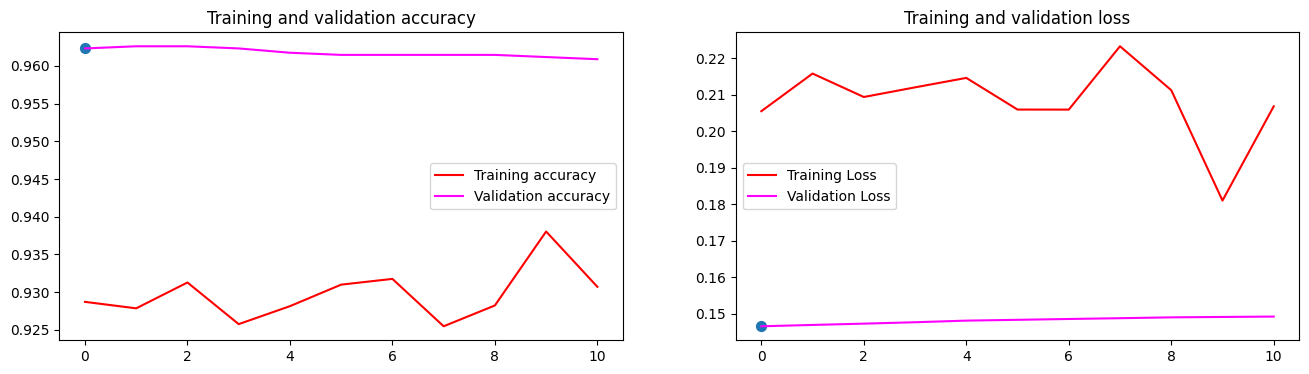

In [64]:
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)

for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=5e-3),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=4, verbose=1, min_lr=1e-7)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

## Evaluations

Total Epochs: range(0, 64)


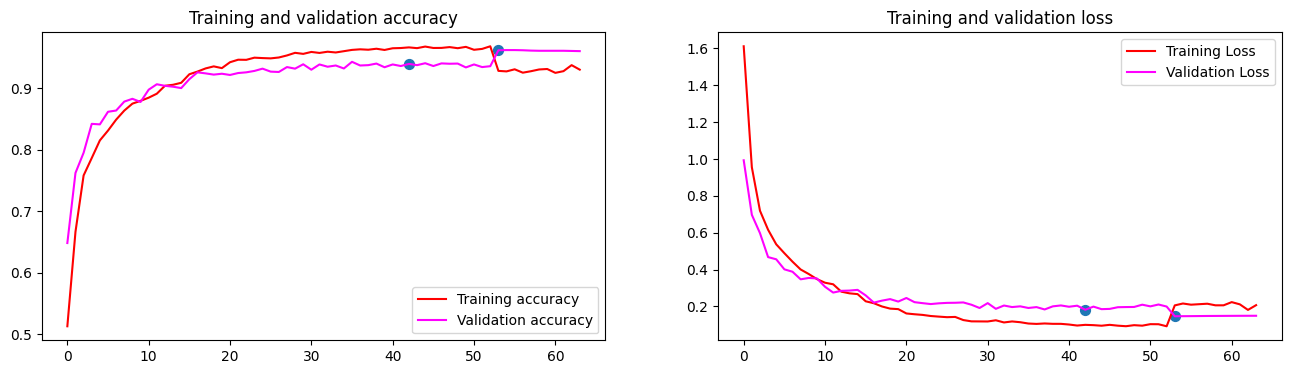

In [65]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 53)


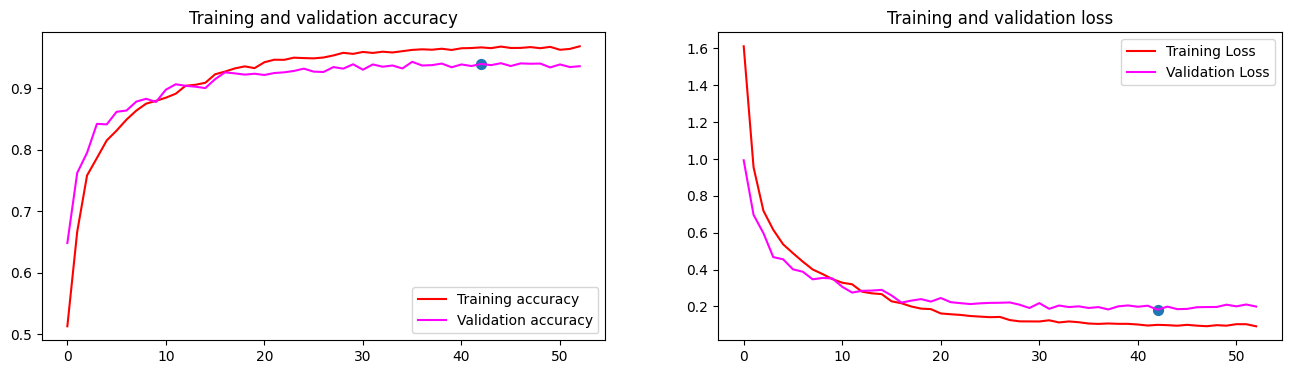

Total Epochs: range(0, 11)


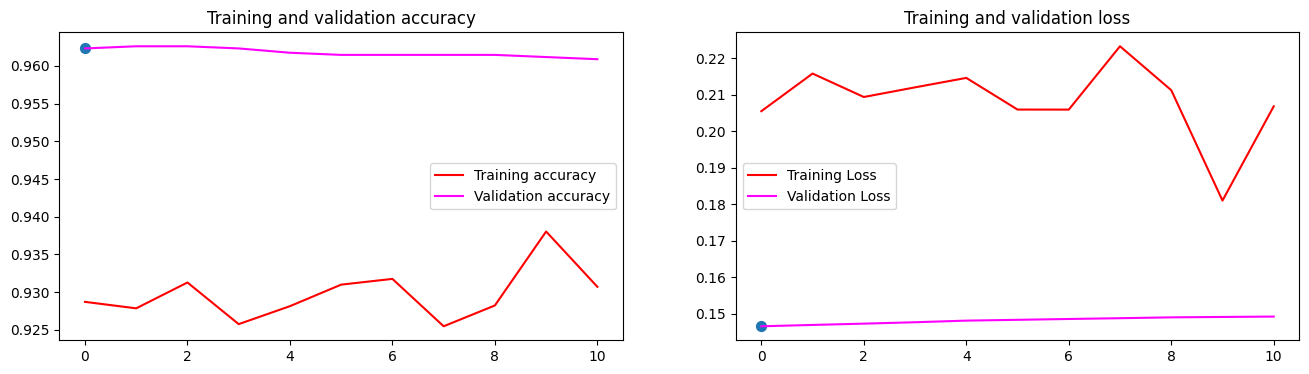

In [66]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
219/219 [==============================] - 5s 23ms/step - loss: 0.1465 - accuracy: 0.9623
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93897   0.88889   0.91324       225
       Lantana    0.95545   0.91038   0.93237       212
   Parkinsonia    0.99024   0.98544   0.98783       206
    Parthenium    0.91781   0.98049   0.94811       205
Prickly acacia    0.94762   0.93427   0.94090       213
   Rubber vine    0.95238   0.99010   0.97087       202
     Siam weed    0.98086   0.95349   0.96698       215
    Snake weed    0.90640   0.90640   0.90640       203
      Negative    0.97488   0.98023   0.97755      1821

      accuracy                        0.96231      3502
     macro avg    0.95162   0.94774   0.94936      3502
  weighted avg    0.96240   0.96231   0.96218      3502


                False Positive Rate  Accuracy
Chinee apple               0.003967  0.888889
Lantana                    0.002736  0.910377
Parkinsonia                0.000607  0.985437
Parthenium                 0.005460  0.980488
Prickly acacia    

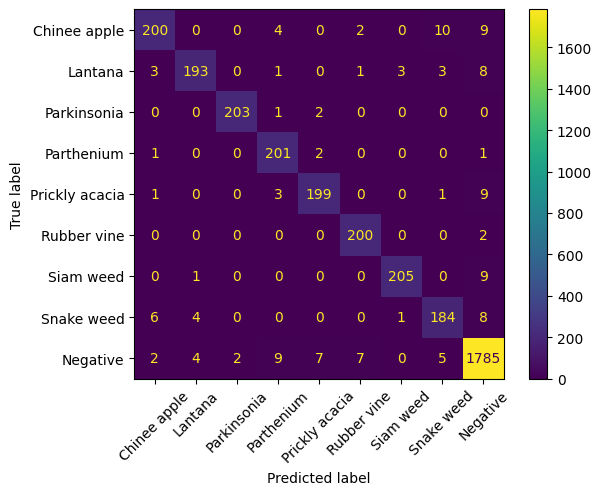

'Threshold = 0.1111111119389534'

In [67]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

### Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 [==============================] - 5s 23ms/step - loss: 0.1533 - accuracy: 0.9586
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93151   0.90667   0.91892       225
       Lantana    0.95714   0.94366   0.95035       213
   Parkinsonia    0.97549   0.96602   0.97073       206
    Parthenium    0.93458   0.98039   0.95694       204
Prickly acacia    0.94762   0.93868   0.94313       212
   Rubber vine    0.93396   0.98020   0.95652       202
     Siam weed    0.95735   0.93953   0.94836       215
    Snake weed    0.91710   0.87192   0.89394       203
      Negative    0.97155   0.97529   0.97342      1821

      accuracy                        0.95858      3501
     macro avg    0.94737   0.94471   0.94581      3501
  weighted avg    0.95853   0.95858   0.95844      3501


                False Positive Rate  Accuracy
Chinee apple               0.004579  0.906667
Lantana                    0.002737  0.943662
Parkinsonia                0.001517  0.966019
Parthenium                 0.004246  0.980392
Prickly acacia    

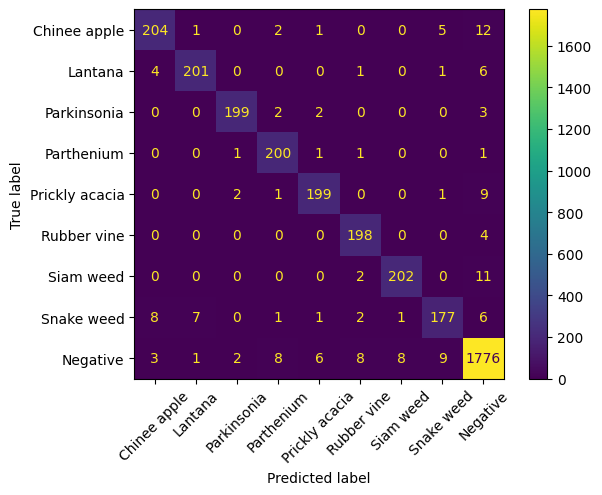

In [68]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

### Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90086   0.92889   0.91466       225
       Lantana    0.92237   0.94836   0.93519       213
   Parkinsonia    0.97549   0.96602   0.97073       206
    Parthenium    0.93396   0.97059   0.95192       204
Prickly acacia    0.93056   0.94811   0.93925       212
   Rubber vine    0.92958   0.98020   0.95422       202
     Siam weed    0.95755   0.94419   0.95082       215
    Snake weed    0.91710   0.87192   0.89394       203
      Negative    0.97778   0.96650   0.97211      1821

      accuracy                        0.95601      3501
     macro avg    0.93836   0.94720   0.94254      3501
  weighted avg    0.95637   0.95601   0.95605      3501


                False Positive Rate  Accuracy
Chinee apple               0.007021  0.928889
Lantana            

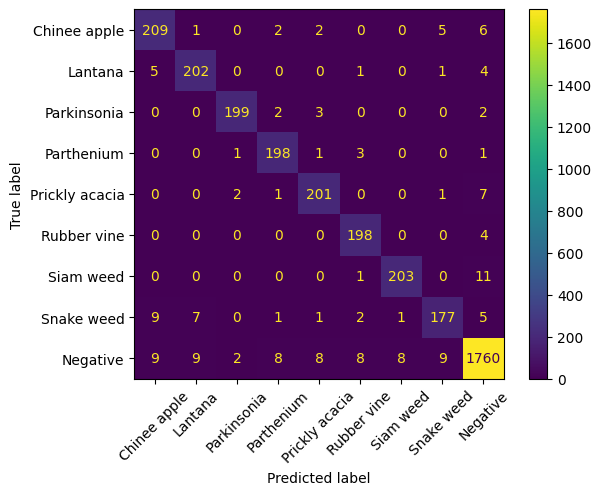

In [69]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)